Copyright (c) Meta Platforms, Inc. and affiliates.
All rights reserved.

This source code is licensed under the license found in the
LICENSE file in the root directory of this source tree.

The project is CC-BY-NC licensed, as found in the LICENSE file of the github.

# Demo of image watermarking with Stable Signature's pre-trained HiDDeN model 

Clone repo:

In [1]:
!git clone https://github.com/facebookresearch/stable_signature.git
%cd stable_signature/hidden

Cloning into 'stable_signature'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 177 (delta 23), reused 18 (delta 18), pack-reused 141
Receiving objects: 100% (177/177), 9.27 MiB | 20.78 MiB/s, done.
Resolving deltas: 100% (34/34), done.
/home/host_mueller/mueller/git/stable_signature/hidden/notebooks/stable_signature/hidden


Install requirements:

In [2]:
!pip install -r requirements.txt

INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install -r requirements.txt (line 5) and scipy==1.10.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested scipy==1.10.1
    scikit-image 0.20.0 depends on scipy<1.9.2 and >=1.8; python_version <= "3.9"

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [ ]:
# Resolve issue in Augly library
!sudo apt-get install python3-magic

[sudo] password for mueller: 

Imports

In [1]:

import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# you should run this notebook in the root directory of the hidden project for the following imports to work
# %cd ..
from models import HiddenEncoder, HiddenDecoder, EncoderWithJND, EncoderDecoder
from attenuations import JND

In [2]:
def msg2str(msg):
    return "".join([('1' if el else '0') for el in msg])

def str2msg(str):
    return [True if el=='1' else False for el in str]

### Load and build models 

The watermark signal can be rescaled with a factor `scaling_w`.

We use the just noticeable difference (JND) heatmap presented in https://github.com/facebookresearch/active_indexing to mask the watermark signal in areas where the eye is sensitive to changes.
This allows to impose perceptual constraint, in case we want to use the trained encoder to watermark images.

In [3]:
class Params():
    def __init__(self, encoder_depth:int, encoder_channels:int, decoder_depth:int, decoder_channels:int, num_bits:int,
                attenuation:str, scale_channels:bool, scaling_i:float, scaling_w:float):
        # encoder and decoder parameters
        self.encoder_depth = encoder_depth
        self.encoder_channels = encoder_channels
        self.decoder_depth = decoder_depth
        self.decoder_channels = decoder_channels
        self.num_bits = num_bits
        # attenuation parameters
        self.attenuation = attenuation
        self.scale_channels = scale_channels
        self.scaling_i = scaling_i
        self.scaling_w = scaling_w

NORMALIZE_IMAGENET = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
UNNORMALIZE_IMAGENET = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
default_transform = transforms.Compose([transforms.ToTensor(), NORMALIZE_IMAGENET])

params = Params(
    encoder_depth=4, encoder_channels=64, decoder_depth=8, decoder_channels=64, num_bits=48,
    attenuation="jnd", scale_channels=False, scaling_i=1, scaling_w=1.5
)

decoder = HiddenDecoder(
    num_blocks=params.decoder_depth, 
    num_bits=params.num_bits, 
    channels=params.decoder_channels
)
encoder = HiddenEncoder(
    num_blocks=params.encoder_depth, 
    num_bits=params.num_bits, 
    channels=params.encoder_channels
)
attenuation = JND(preprocess=UNNORMALIZE_IMAGENET) if params.attenuation == "jnd" else None
encoder_with_jnd = EncoderWithJND(
    encoder, attenuation, params.scale_channels, params.scaling_i, params.scaling_w
)

In [4]:
ckpt_path = "../ckpts/hidden_replicate.pth"

state_dict = torch.load(ckpt_path, map_location='cpu')['encoder_decoder']
encoder_decoder_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
encoder_state_dict = {k.replace('encoder.', ''): v for k, v in encoder_decoder_state_dict.items() if 'encoder' in k}
decoder_state_dict = {k.replace('decoder.', ''): v for k, v in encoder_decoder_state_dict.items() if 'decoder' in k}

encoder.load_state_dict(encoder_state_dict)
decoder.load_state_dict(decoder_state_dict)

encoder_with_jnd = encoder_with_jnd.to(device).eval()
decoder = decoder.to(device).eval()

### Tests

PSNR: 35.10610650374143
Message: 111010110101000001010111010011010100010000100111
Decoded: 111010110101000001010111010011010100010000100111
Bit Accuracy: 1.0


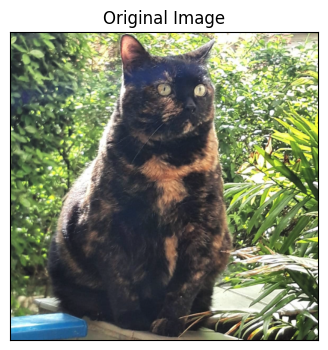

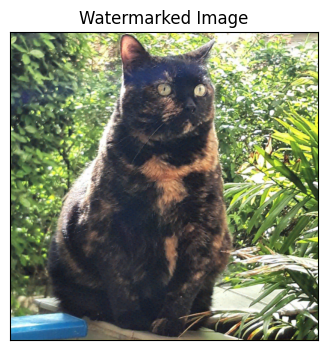

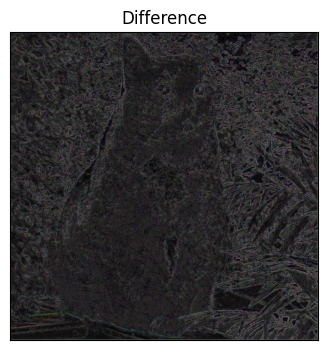

In [5]:
# load image
img = Image.open("../imgs/00.png").convert('RGB')
img = img.resize((512, 512), Image.BICUBIC)
img_pt = default_transform(img).unsqueeze(0).to(device)

# create message
random_msg = False
if random_msg:
    msg_ori = torch.randint(0, 2, (1, params.num_bits), device=device).bool() # b k
else:
    msg_ori = torch.Tensor(str2msg("111010110101000001010111010011010100010000100111")).unsqueeze(0)
msg = 2 * msg_ori.type(torch.float) - 1 # b k

# encode
img_w = encoder_with_jnd(img_pt, msg)
clip_img = torch.clamp(UNNORMALIZE_IMAGENET(img_w), 0, 1)
clip_img = torch.round(255 * clip_img)/255 
clip_img = transforms.ToPILImage()(clip_img.squeeze(0).cpu())

# psnr
psnr = peak_signal_noise_ratio(np.array(img), np.array(clip_img))
print(f"PSNR: {psnr}")

# plot
plt.figure(figsize=(4, 4))
plt.grid('off')
plt.xticks([])
plt.yticks([])
plt.title("Original Image")
plt.imshow(img)
plt.figure(figsize=(4, 4))
plt.grid('off')
plt.xticks([])
plt.yticks([])
plt.title("Watermarked Image")
plt.imshow(clip_img)
diff = np.abs(np.asarray(img).astype(int) - np.asarray(clip_img).astype(int)) / 255 * 10
plt.figure(figsize=(4, 4))
plt.grid('off')
plt.xticks([])
plt.yticks([])
plt.title("Difference")
plt.imshow(diff)

# decode
ft = decoder(default_transform(clip_img).unsqueeze(0).to(device))
decoded_msg = ft > 0 # b k -> b k
accs = (~torch.logical_xor(decoded_msg, msg_ori)) # b k -> b k
print(f"Message: {msg2str(msg_ori.squeeze(0).cpu().numpy())}")
print(f"Decoded: {msg2str(decoded_msg.squeeze(0).cpu().numpy())}")
print(f"Bit Accuracy: {accs.sum().item() / params.num_bits}")